# Resource-Constrained Project Scheduling with Time-Offs

This notebook addresses RCPSP variants where resources have individual availability calendars. It explores six problems that differ in how tasks handle interruptions and resource reassignments. Each resource unit of each resource type has its own availability calendar (available/unavailable periods). Preemption is possible either by changing resource units of the same resource type during execution (if migration is allowed) or by pausing the task execution according to its calendar (and after the pause continuing on the same resource unit).

1. **No Migration | No Delays**: Tasks execute continuously without interruption, resources must be available throughout entire task duration
2. **Migration | No Delays**: Tasks pause and immediately switch to available alternative resources
3. **No Migration | Delays | Blocked**: Tasks pause when resources are unavailable, resume later on the same resources; resources remain blocked during pauses
4. **Migration | Delays**: Combines pausing with the ability to switch resource units
5. **Multi-Resource Heterogeneous Policy**: Different resource types follow different policies; e.g., machines require fixed assignment while workers allow migration. No Migration | No Delays + Migration policy | No Delays
6. **No Migration | Delays | Released**: Tasks pause when resources are unavailable, resume later on the same resources; resources are released during pauses and can work on other tasks

## Parsing, Loading, Helper Functions

### Imports & Parsing

In [1]:
import docplex.cp.utils_visu as visu
import matplotlib as plt
from itertools import combinations, product
from docplex.cp.model import CpoStepFunction

In [2]:
def next_line(f):
    """Read next non-empty, non-comment line."""
    while True:
        raw = f.readline()
        if not raw:
            return None
        line = raw.strip()
        if not line or line.startswith('#'):
            continue
        return [int(v) for v in line.split()]

In [3]:
def load_instance(filename):
    """Load RCPSP instance with explicit resource types.
    Returns: (N, K, M, TASKS, TYPES, UNITS, PRECEDENCES) where
        - N: number of tasks
        - K: number of resource types
        - M: number of resource units
        - TASKS: [(task_id, size, [(type_id, qty), ...]), ...]
        - TYPES: [(type_id, [unit_ids]), ...]
        - UNITS: [(unit_id, [(time, intensity), ...]), ...]
        - PRECEDENCES: [(pred_task, succ_task), ...]
    """
    with open(filename, "r") as f:
        N, K, M = next_line(f)
        TYPES = [(d[0], d[2:2+d[1]]) for d in (next_line(f) for _ in range(K))]
        UNITS = [(d[0], [(d[2+2*i], d[3+2*i]) for i in range(d[1])]) 
                 for d in (next_line(f) for _ in range(M))]
        TASKS = [(d[0], d[1], [tuple(next_line(f)[:2]) for _ in range(d[2])]) 
                 for d in (next_line(f) for _ in range(N))]
        PRECEDENCES = [tuple(next_line(f)[:2]) for _ in range(next_line(f)[0])]
    return N, K, M, TASKS, TYPES, UNITS, PRECEDENCES

### Helper Functions and Data Structures

In [4]:
HORIZON = 100_000

# === Core Helpers ===
def get_availability(unit_id, time, res_map):
    """Returns availability (0 or 100) of a unit at a specific time."""
    return next((v for t, v in reversed(res_map[unit_id]) if time >= t), 0)

def step_function(steps, horizon=HORIZON):
    """Create CpoStepFunction from [(time, value), ...] pairs."""
    f = CpoStepFunction()
    for i, (t, v) in enumerate(steps):
        end = steps[i + 1][0] if i + 1 < len(steps) else horizon
        f.set_value(t, end, v)
    return f

# === Resource Processing ===
def prepare_types(TYPES):
    """type_id -> {name, units, capacity}"""
    return {tid: {"name": f"Type_{tid}", "units": units, "capacity": len(units)} 
            for tid, units in TYPES}

def extract_breaks(UNITS, horizon=HORIZON):
    """Extract (start, duration) pairs where unit is unavailable."""
    return {
        uid: [(t, (steps[i+1][0] if i+1 < len(steps) else horizon) - t)
              for i, (t, v) in enumerate(steps) if v == 0 
              and t < (steps[i+1][0] if i+1 < len(steps) else horizon)]
        for uid, steps in UNITS if any(v == 0 for _, v in steps)
    }

def joint_intensity(unit_ids, res_map, horizon=HORIZON):
    """CpoStepFunction: 100 only when ALL units available simultaneously."""
    if not unit_ids:
        return CpoStepFunction(steps=[(0, 100)])
    
    times = sorted({0} | {t for uid in unit_ids for t, _ in res_map[uid]})
    steps = [(t, 100 if all(get_availability(u, t, res_map) for u in unit_ids) else 0)
             for t in times]
    return step_function(steps, horizon)

# === Mode Generation ===
def build_modes(TASKS, TYPE_MAP):
    """Generate all valid unit combinations for each task."""
    result = {}
    for tid, size, reqs in TASKS:
        if not reqs or all(qty == 0 for _, qty in reqs):
            result[tid] = [()]
            continue
        combos = [list(combinations(TYPE_MAP[t], q)) if q > 0 else [()] for t, q in reqs]
        result[tid] = [tuple(sorted({r for grp in c for r in grp})) for c in product(*combos)] or [()]
    return result

def capacity_windows(reqs, TYPE_MAP, RES_MAP, horizon=HORIZON):
    """Find windows where aggregate capacity >= requirements."""
    if not reqs or all(qty == 0 for _, qty in reqs):
        return [(0, horizon)]
    
    times = sorted({0, horizon} | {t for tid, qty in reqs if qty > 0 
                                   for r in TYPE_MAP[tid] if r in RES_MAP 
                                   for t, _ in RES_MAP[r]})
    
    def feasible(t):
        return all(sum(get_availability(r, t, RES_MAP) > 0 for r in TYPE_MAP[tid]) >= qty 
                   for tid, qty in reqs if qty > 0)
    
    # Merge adjacent feasible intervals
    windows = []
    for i in range(len(times) - 1):
        if feasible(times[i]):
            if windows and windows[-1][1] == times[i]:
                windows[-1] = (windows[-1][0], times[i + 1])
            else:
                windows.append((times[i], times[i + 1]))
    return windows

# === Solution Extraction ===
def extract_modes(sol, unit_intervals, T):
    """Extract selected mode from unit intervals."""
    return {
        (tid, selected): unit_intervals[(tid, selected[0])]
        for tid in T
        if (selected := tuple(sorted(r for (t, r), itv in unit_intervals.items() 
                                      if t == tid and (s := sol.get_var_solution(itv)) 
                                      and s.is_present())))
    }

def greedy_assign(sol, T, TASKS, TYPE_MAP, RES_MAP, horizon=HORIZON):
    """Post-process pulse-based solution to assign specific units."""
    avail = {r: [(t, steps[i+1][0] if i+1 < len(steps) else horizon)
                 for i, (t, v) in enumerate(steps) if v > 0]
             for r, steps in RES_MAP.items()}
    assignments, used = {}, {r: [] for r in RES_MAP}
    def is_free(r, t):
        return (any(s <= t < e for s, e in avail.get(r, [])) 
                and all(not (s <= t < e) for s, e in used[r]))
    
    for tid, start, end in sorted(((tid, s.get_start(), s.get_end()) 
                                    for tid, itv in T.items() 
                                    if (s := sol.get_var_solution(itv))), key=lambda x: x[1]):
        reqs, segments, t = TASKS[tid][2], [], start
        if start == end or not reqs or all(q == 0 for _, q in reqs):
            assignments[tid] = []
            continue
        
        while t < end:
            selected = []
            for type_id, qty in reqs:
                if qty <= 0:
                    continue
                free_units = [r for r in TYPE_MAP[type_id] if is_free(r, t)]
                if len(free_units) < qty:
                    selected = []
                    break
                selected.extend(free_units[:qty])
            
            if not selected:
                break
            
            seg_end = min(min(e for r in selected for s, e in avail[r] if s <= t < e), end)
            segments.append((t, seg_end, tuple(sorted(selected))))
            for r in selected:
                used[r].append((t, seg_end))
            t = seg_end
        
        assignments[tid] = segments
    return assignments

def extract_segments(sol, segments, task_windows, TASKS, TYPE_MAP, RES_MAP):
    """Post-process segment-based solution to assign specific units per segment."""
    active = []
    for tid, size, reqs in TASKS:
        for w_idx in range(len(task_windows[tid])):
            seg_sol = sol.get_var_solution(segments[(tid, w_idx)])
            if seg_sol and seg_sol.is_present() and seg_sol.get_size() > 0:
                active.append((tid, reqs, seg_sol.get_start(), seg_sol.get_end()))
    times = set()
    for tid, reqs, s, e in active:
        times |= {s, e}
        for k, q in reqs:
            if q > 0:
                for r in TYPE_MAP[k]:
                    if r in RES_MAP:
                        times |= {t for t, _ in RES_MAP[r] if s < t < e}
    times = sorted(times)
    assignments = {tid: [] for tid, _, _ in TASKS}
    
    for i in range(len(times) - 1):
        ts, te = times[i], times[i + 1]
        used = set() 
        for tid, reqs in sorted([(tid, reqs) for tid, reqs, s, e in active if s <= ts < e]):
            units = []
            for k, q in reqs:
                if q > 0:
                    # Only pick units that are: (1) calendar-available AND (2) not used by another task
                    avail = [r for r in TYPE_MAP[k] 
                             if get_availability(r, ts, RES_MAP) > 0 and r not in used]
                    units.extend(avail[:q])
            
            if units:
                res = tuple(sorted(set(units)))
                # Merge with previous segment if same resources and contiguous
                if assignments[tid] and assignments[tid][-1][1] == ts and assignments[tid][-1][2] == res:
                    assignments[tid][-1] = (assignments[tid][-1][0], te, res)
                else:
                    assignments[tid].append((ts, te, res))
                used.update(units)
    return assignments

def extract_heterogeneous(sol, T, TASKS, TYPE_MAP, RES_MAP, Unit_Intervals, FIXED_TYPES, MIGRATION_TYPES):
    """Extract all assignments (fixed + migration) into unified format."""
    avail = {r: [(t, steps[i+1][0] if i+1 < len(steps) else HORIZON)
                 for i, (t, v) in enumerate(steps) if v > 0] for r, steps in RES_MAP.items()}
    assignments, used = {}, {r: [] for r in RES_MAP}
    
    is_free = lambda r, t: (any(s <= t < e for s, e in avail.get(r, [])) 
                            and all(not (s <= t < e) for s, e in used[r]))
    for tid, size, reqs in TASKS:
        t_sol = sol.get_var_solution(T[tid])
        if not t_sol or t_sol.get_start() == t_sol.get_end():
            assignments[tid] = []
            continue
        start, end = t_sol.get_start(), t_sol.get_end()
        fixed = [r for (t, r), itv in Unit_Intervals.items() 
                 if t == tid and (s := sol.get_var_solution(itv)) and s.is_present()]
        mig_reqs = [(k, q) for k, q in reqs if k in MIGRATION_TYPES and q > 0]
        if not mig_reqs:
            assignments[tid] = [(start, end, tuple(sorted(fixed)))] if fixed else []
            continue
        segs, t = [], start
        while t < end:
            sel = list(fixed)
            for k, q in mig_reqs:
                sel.extend([r for r in TYPE_MAP[k] if r not in sel and is_free(r, t)][:q])
            if len(sel) <= len(fixed):
                break
            seg_end = min(min(e for r in sel if r not in fixed for s, e in avail[r] if s <= t < e), end)
            segs.append((t, seg_end, tuple(sorted(sel))))
            for r in sel:
                if r not in fixed:
                    used[r].append((t, seg_end))
            t = seg_end
        assignments[tid] = segs
    return assignments

def compute_work_windows(mode, RES_MAP, horizon=HORIZON):
    """Find intervals where ALL units in mode are available."""
    if not mode:
        return [(0, horizon)]
    times = sorted({0, horizon} | {t for r in mode if r in RES_MAP for t, _ in RES_MAP[r]})
    windows = []
    for i in range(len(times) - 1):
        if all(get_availability(r, times[i], RES_MAP) > 0 for r in mode):
            if windows and windows[-1][1] == times[i]:
                windows[-1] = (windows[-1][0], times[i + 1])
            else:
                windows.append((times[i], times[i + 1]))
    return windows

def extract_mode_segments(sol, T, M, S, Task_Modes, Work_Windows, TASKS):
    """Extract segment assignments for the released resources model."""
    assignments = {}
    for tid, size, reqs in TASKS:
        # Find selected mode
        selected_mode = None
        for m in Task_Modes[tid]:
            if (m_sol := sol.get_var_solution(M[(tid, m)])) and m_sol.is_present():
                selected_mode = m
                break
        
        if not selected_mode:
            assignments[tid] = []
            continue
        segs = []
        for w in range(len(Work_Windows[(tid, selected_mode)])):
            if (s_sol := sol.get_var_solution(S[(tid, selected_mode, w)])) and s_sol.is_present() and s_sol.get_size() > 0:
                segs.append((s_sol.get_start(), s_sol.get_end(), selected_mode))
        assignments[tid] = segs
    return assignments

### Visualisation

In [5]:
def print_instance(N, K, M, TASKS, TYPES, UNITS, PRECEDENCES):
    print(f"\n{'='*75}")
    print(f"INSTANCE: {N} Tasks × {K} Types × {M} Units")
    print(f"{'='*75}")
    TYPE_MAP = {tid: units for tid, units in TYPES}
    print("\nResource Types:")
    for type_id, units in TYPES:
        print(f"  Type {type_id}: Units {{{', '.join(f'U{u}' for u in units)}}}")
    print(f"\n{'Task':<6} {'Dur':<4} {'Requirements':<30} {'→ Succ'}")
    print(f"{'-'*75}")
    for tid, size, reqs in TASKS:
        succs = [s for p, s in PRECEDENCES if p == tid]
        if not reqs or all(qty == 0 for _, qty in reqs):
            req_str = "—"
        else:
            req_str = ", ".join([f"{qty}×Type{type_id}" for type_id, qty in reqs if qty > 0])
        print(f"T{tid:<5} {size:<4} {req_str:<30} {succs if succs else '—'}")
    print(f"\n{'Unit':<6} {'Type':<6} {'Available Windows'}")
    print(f"{'-'*75}")
    unit_to_type = {u: tid for tid, units in TYPES for u in units}
    for unit_id, steps in UNITS:
        windows = []
        for i in range(len(steps)):
            if steps[i][1] > 0:
                end = steps[i+1][0] if i+1 < len(steps) else "∞"
                windows.append(f"[{steps[i][0]}-{end})")
        type_id = unit_to_type.get(unit_id, "?")
        print(f"U{unit_id:<5} T{type_id:<5} {' '.join(windows) if windows else '—'}")
    print(f"{'='*75}\n")

In [6]:
def print_solution(sol, T, mode_intervals, N):
    # Detect solver type based on available methods
    is_cpo = hasattr(sol, 'get_objective_values')
    obj_val = sol.get_objective_values()[0] if is_cpo else int(sol.objective_value)
    print(f"\n{'='*75}")
    print(f"✓ SOLUTION - Makespan: {obj_val}")
    print(f"{'='*75}")
    print(f"{'Task':<5} {'Start':<5} {'End':<5} {'Dur':<4} {'Resources'}")
    print(f"{'-'*75}")
    schedule = []
    for i in range(N):
        # Extract Task Start/End
        if is_cpo:
            sol_t = sol.get_var_solution(T[i])
            if not sol_t: continue
            start, end = sol_t.get_start(), sol_t.get_end()
        else:
            # OptalCP logic
            if not sol.solution.is_present(T[i]): continue
            start = sol.solution.get_start(T[i])
            end = sol.solution.get_end(T[i])
        selected = []
        for (tid, m), itv in mode_intervals.items():
            if tid == i:
                is_present = False
                if is_cpo:
                    s_itv = sol.get_var_solution(itv)
                    if s_itv and s_itv.is_present(): is_present = True
                else:
                    if sol.solution.is_present(itv): is_present = True
                if is_present:
                    selected.append(m)
        res_str = "{U" + ",U".join(map(str, sorted(selected))) + "}" if selected else "—"
        schedule.append((i, start, end, end-start, res_str))
        
    for tid, start, end, dur, res in sorted(schedule, key=lambda x: (x[1], x[0])):
        print(f"T{tid:<4} {start:<5} {end:<5} {dur:<4} {res}")
    print(f"{'='*75}\n")

In [7]:
def visualize_schedule(sol, RES_MAP, M, TYPES, 
                       mode_intervals=None, assignments=None,
                       figsize=(12, 4), origin=0, horizon=None):
    plt.rcParams["figure.figsize"] = figsize
    task_colors = ['steelblue', 'coral', 'gold', 'mediumpurple', 'darkcyan', 'sandybrown']
    break_color = 'lightgray'
    unit_to_type = {u: tid for tid, units in TYPES for u in units}
    if horizon is None:
        horizon = max(t for steps in RES_MAP.values() for t, _ in steps)
    
    def is_available(r, t):
        """Check if resource r is available at time t."""
        if r not in RES_MAP:
            return True
        steps = RES_MAP[r]
        for i, (st, v) in enumerate(steps):
            next_t = steps[i + 1][0] if i + 1 < len(steps) else float('inf')
            if st <= t < next_t:
                return v > 0
        return False
    
    def compute_work_segments(start, end, mode_resources):
        """Split interval into working and break segments based on joint availability."""
        change_points = {start, end}
        for r in mode_resources:
            if r in RES_MAP:
                for t, _ in RES_MAP[r]:
                    if start < t < end:
                        change_points.add(t)
        change_points = sorted(change_points)
        
        segments = []
        for i in range(len(change_points) - 1):
            seg_start, seg_end = change_points[i], change_points[i + 1]
            is_working = all(is_available(r, seg_start) for r in mode_resources)
            segments.append((seg_start, seg_end, is_working))
        return segments
    
    visu.timeline(origin=origin, horizon=horizon)
    visu.panel('Calendars')
    for r in range(M):
        type_id = unit_to_type.get(r, "?")
        visu.sequence(name=f'T{type_id}[U{r}]')
        if r in RES_MAP:
            steps = RES_MAP[r]
            for i, (t, v) in enumerate(steps):
                next_t = steps[i + 1][0] if i + 1 < len(steps) else horizon + 1
                if v > 0:
                    visu.interval(t, next_t, 'lightgreen')
    
    visu.panel('Assignments')
    for r in range(M):
        type_id = unit_to_type.get(r, "?")
        visu.sequence(name=f'T{type_id}[U{r}]')
        
        if mode_intervals:
            for (tid, m_res), itv in mode_intervals.items():
                if r in m_res:
                    sol_itv = sol.get_var_solution(itv)
                    if sol_itv and sol_itv.is_present():
                        start, end = sol_itv.get_start(), sol_itv.get_end()
                        segments = compute_work_segments(start, end, m_res)
                        task_col = task_colors[tid % len(task_colors)]
                        for seg_start, seg_end, is_working in segments:
                            col = task_col if is_working else break_color
                            label = f"T{tid}" if is_working else ""
                            visu.interval(seg_start, seg_end, col, label)
        
        if assignments:
            for tid, segs in assignments.items():
                for start, end, res in segs:
                    if r in res:
                        col = task_colors[tid % len(task_colors)]
                        visu.interval(start, end, col, f"T{tid}")
    
    visu.show()

### Load Instance

In [8]:
from docplex.cp.model import *

In [9]:
filename = "../data/rcpspblocking/02.data"

N, K, R, TASKS, TYPES, UNITS, PRECEDENCES = load_instance(filename)
RES_MAP = dict(UNITS)
TYPE_MAP = dict(TYPES)
print_instance(N, K, R, TASKS, TYPES, UNITS, PRECEDENCES)


INSTANCE: 5 Tasks × 2 Types × 4 Units

Resource Types:
  Type 0: Units {U0, U1}
  Type 1: Units {U2, U3}

Task   Dur  Requirements                   → Succ
---------------------------------------------------------------------------
T0     0    —                              [1, 2, 3]
T1     5    1×Type0, 1×Type1               [4]
T2     2    1×Type0, 1×Type1               [4]
T3     1    1×Type0                        [4]
T4     0    —                              —

Unit   Type   Available Windows
---------------------------------------------------------------------------
U0     T0     [1-7) [9-15)
U1     T0     [2-3) [8-9) [10-15)
U2     T1     [2-3) [8-9) [10-15)
U3     T1     [1-2) [3-7) [9-10) [11-15)



## 1. No Migration | No Delays

Tasks must execute continuously without any interruption. Each task is assigned to a specific combination of resource units that it requires, and all these selected resource units must be continuously available throughout the entire task execution. No calendar-based pausing is allowed—if resources have time-offs, the task must be scheduled entirely within a single availability window where all required units of all resource types are continuously accessible.

$$
\begin{aligned}
\min \quad
& \max_{i \in \mathcal{N}} (\operatorname{end}(T_i))
& & \text{ (1)} \\[2mm]
\text{s.t.} \quad
& \operatorname{endBeforeStart}(T_i, T_j),
& \forall (i, j) \in \mathcal{E}
& \text{ (2)} \\[2mm]
& \operatorname{alternative}(T_i, \{O_{i,r} \mid r \in \mathcal{U}_k\}, q_{i,k}),
& \forall i \in \mathcal{N}, \forall k \in \mathcal{K}_i
& \text{ (3)} \\[2mm]
& \operatorname{noOverlap}(\{O_{i,r} \mid i \in \mathcal{N}: r \in \mathcal{C}_i\}),
& \forall r \in \mathcal{R}
& \text{ (4)} \\[2mm]
& \operatorname{forbidExtent}(O_{i,r}, \overline{\mathcal{F}_r}),
& \forall i \in \mathcal{N} \forall r \in \mathcal{C}_i
& \text{ (5)} \\[2mm]
& T_i: \text{mandatory interval var with size } d_i
& \forall i \in \mathcal{N}
& \text{ (6a)} \\[1mm]
& O_{i,r}: \text{optional interval var with size } d_i
& \forall i \in \mathcal{N}, \forall r \in \mathcal{C}_i
& \text{ (6b)}
\end{aligned}
$$

**Objective**
- **(1)** Minimize the project completion time.

**Modeling Constraints**
- **(2)** Precedence relations - standard finish-to-start dependencies.
- **(3)** For each task $i$: for each resource type requirement (for each resource type $k$ from requirements for task $i$ $\mathcal{K}_i$), select exactly $q_{i,k}$ resource units. The `alternative` with cardinality $q_{i,k}$ ensures all selected intervals share the same start/end as $T_i$.
- **(4)** Resource exclusivity: For each resource unit $r$, a `noOverlap` constraint is applied to all task intervals $O_{i,r}$ where $r$ is a candidate for task $i$ (i.e., $r \in \mathcal{C}_i$), ensuring that at most one task can use $r$ at any given time.
- **(5)** Calendar Compliance: Each resource unit interval must fall within the unit's availability windows.

**Variable Definitions**
- **(6a)** $T_i$: Master interval with fixed size $d_i$.
- **(6b)** $O_{i,r}$: Optional interval for task $i$ on resource unit $r$.

**Sets & Parameters**
- $\mathcal{N}$: Set of tasks to be scheduled
- $\mathcal{E}$: Set of precedence relations (finish-to-start dependencies)
* $\mathcal{K}_i$: resource types required by task $i$
* $\mathcal{U}_k$: candidate resource units for resource type $k$
* $\mathcal{R}$: Set of all resource units in the entire system (of all resource types)
* $q_{i,k}$: number of resource units of resource type $k$ required by task $i$
* $\mathcal{C}_i = \bigcup_{k \in \mathcal{K}_i} \mathcal{U}_k$: all candidate resource units of all resource types for task $i$
* $\mathcal{F}_r(t) \in \{0, 1\}$: Availability calendar (step function) for resource unit $r$

### IBM CPO DOcplex Implementation

#### Prepare Data

In [10]:
# F_r: Individual availability step function for each resource unit
res_availability = {unit_id: step_function(steps) 
                    for unit_id, steps in UNITS}

#### Create model and variables

In [11]:
mdl = CpoModel(name="rcpsp_nonpreemptive_nomigration_cpo")

# (6a) T_i: mandatory interval var with fixed size d_i
T = {tid: interval_var(size=size, name=f"T{tid}") for tid, size, _ in TASKS}

# (6b) O_{i,r}: optional interval var for each task-resource unit pair
# Only create intervals for units that are candidates for the task
O = {
    (i, r): interval_var(size=size, optional=True, name=f"T{i}_U{r}")
    for i, size, requirements in TASKS
    for type_id, quantity in requirements
    for r in TYPE_MAP[type_id]
}

#### Add constraints and objective

In [12]:
# (1) objective: minimize makespan
mdl.add(minimize(max([end_of(T[i]) for i in T])))

In [13]:
# (2) precedences
mdl.add([end_before_start(T[i], T[j]) for i, j in PRECEDENCES])

# (3) alternative with cardinality: select q_k units from each resource type
for i, size, requirements in TASKS:
    for type_id, quantity in requirements:
        if quantity > 0 and (candidates := TYPE_MAP[type_id]):
            mdl.add(alternative(T[i], [O[(i, r)] for r in candidates], cardinality=quantity))

# (4) resource capacity: noOverlap per resource unit
for r in range(R):
    if intervals := [int_var for (i, unit_id), int_var in O.items() if unit_id == r]:
        mdl.add(no_overlap(intervals))

# (5) calendar compliance: forbidExtent for each unit interval
for (i, r), int_var in O.items():
    if r in res_availability:
        mdl.add(forbid_extent(int_var, res_availability[r]))

In [14]:
print("Solving Non-Preemptive | No Migration...")
if sol := mdl.solve(LogVerbosity='Quiet'):
    mode_intervals = extract_modes(sol, O, T)
    print_solution(sol, T, mode_intervals, N)

Solving Non-Preemptive | No Migration...

✓ SOLUTION - Makespan: 15
Task  Start End   Dur  Resources
---------------------------------------------------------------------------
T0    0     0     0    —
T3    1     2     1    {U(0,)}
T2    3     5     2    {U(0, 3)}
T1    10    15    5    {U(1, 2)}
T4    15    15    0    —



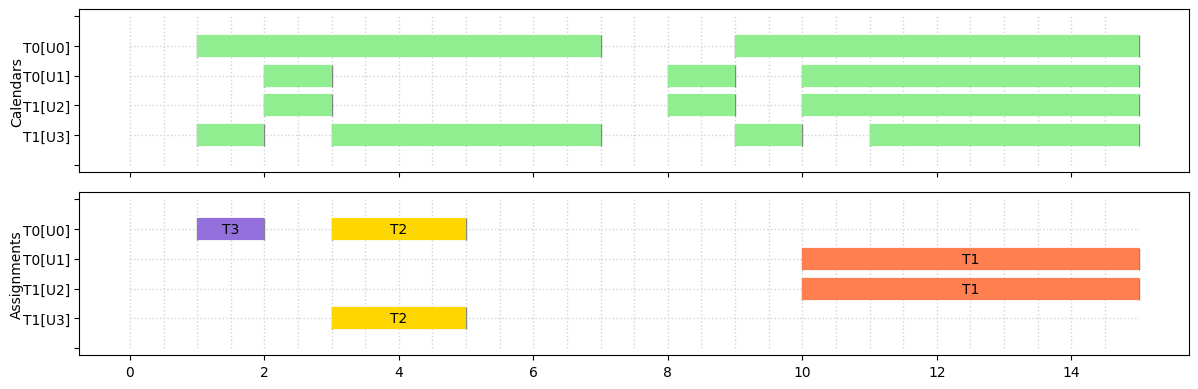

In [15]:
visualize_schedule(sol, RES_MAP, R, TYPES, mode_intervals=mode_intervals, origin=0, horizon=12)

#### Note on the constraint (4)

**Instance:**
- T1 (dur=4): 1×Type0, 1×Type1 → candidates {U0,U1,U2,U3}
- T2 (dur=2): 1×Type0, 1×Type1 → candidates {U0,U1,U2,U3}
- T3 (dur=1): 1×Type0 → candidates {U0,U1}

**Created O variables:**
- T1: O(1,0), O(1,1), O(1,2), O(1,3)
- T2: O(2,0), O(2,1), O(2,2), O(2,3)
- T3: O(3,0), O(3,1)

**Constraint (4) - noOverlap per resource unit:**

| Unit | noOverlap |
|------|-----------|
| U0 | `[O(1,0), O(2,0), O(3,0)]` |
| U1 | `[O(1,1), O(2,1), O(3,1)]` |
| U2 | `[O(1,2), O(2,2)]` |
| U3 | `[O(1,3), O(2,3)]` |

No duplicates - each constraint covers a different resource unit.

### OptalCP Implementation

In [16]:
import optalcp as cp

# Create OptalCP Model
mdl = cp.Model(name="rcpsp_nonpreemptive_nomigration_optal")

# Resource availability functions
# OptalCP step functions expect steps as list of [time, value] pairs
res_availability = {unit_id: mdl.step_function(steps) 
                    for unit_id, steps in UNITS}


# (6a) T_i: mandatory interval var for each task
T = {tid: mdl.interval_var(length=size, name=f"T{tid}") for tid, size, _ in TASKS}

# (6b) O_{i,r}: optional interval var for each task-resource unit pair
O = {
    (i, r): mdl.interval_var(length=size, optional=True, name=f"T{i}_U{r}")
    for i, size, requirements in TASKS
    for type_id, quantity in requirements
    for r in TYPE_MAP[type_id]
}

# (1) Objective: minimize makespan
mdl.minimize(mdl.max([T[i].end() for i in T]))

# (2) Precedences
mdl.add([T[i].end_before_start(T[j]) for i, j in PRECEDENCES])

# (3) Alternative with cardinality decomposition
# Since OptalCP 'alternative' selects exactly one, we decompose the logic for 'quantity' units
for i, size, requirements in TASKS:
    for type_id, quantity in requirements:
        if quantity > 0 and (candidates := TYPE_MAP[type_id]):
            candidate_intervals = [O[(i, r)] for r in candidates]
            
            # A. Cardinality: Ensure exactly 'quantity' units are present
            mdl.add(mdl.sum([int_var.presence() for int_var in candidate_intervals]) == quantity)
            
            # B. Synchronization: If a unit is selected (present), it must run synchronously with T[i]
            # start_at_start constraint is satisfied if the optional interval is absent
            mdl.add([T[i].start_at_start(int_var) for int_var in candidate_intervals])

# (4) Resource capacity: no_overlap per resource unit
for r in range(R):
    if intervals := [int_var for (i, unit_id), int_var in O.items() if unit_id == r]:
        mdl.add(mdl.no_overlap(intervals))

# (5) Calendar compliance: forbid_extent for each unit interval
for (i, r), int_var in O.items():
    if r in res_availability:
        mdl.add(int_var.forbid_extent(res_availability[r]))

print("Solving Non-Preemptive | No Migration (OptalCP)...")
if sol := mdl.solve(cp.Parameters(timeLimit=10, logLevel=0)):
    print_solution(sol, T, O, N)

Solving Non-Preemptive | No Migration (OptalCP)...

✓ SOLUTION - Makespan: 15
Task  Start End   Dur  Resources
---------------------------------------------------------------------------
T0    0     0     0    {U0,U1,U2,U3}
T3    1     2     1    {U0}
T2    3     5     2    {U0,U3}
T1    10    15    5    {U0,U2}
T4    15    15    0    {U0,U1,U2,U3}



## 2. Migration | No Delays

This formulation models a scenario where tasks must execute continuously without time-based interruptions (No Delays), but are allowed to switch between different specific resource units during execution (Migration). Instead of assigning a task to a specific machine or worker for its entire duration, the model calculates the aggregated capacity of all resource units within a resource type (summing the availability calendars). As long as the total available capacity at every moment of the task's execution is sufficient to meet the demand, the task is valid.

$$
\begin{aligned}
\min \quad
& \max_{i \in \mathcal{N}} (\operatorname{end}(T_i))
& & \text{ (1)} \\[2mm]
\text{s.t.} \quad
& \operatorname{endBeforeStart}(T_i, T_j),
& \forall (i, j) \in \mathcal{E}
& \text{ (2)} \\[2mm]
& \sum_{i \in \mathcal{N}} \operatorname{pulse}(T_i, q_{i,k}) \leq A_k,
& \forall k \in \mathcal{K}
& \text{ (3)} \\[2mm]
& A_k(t) = \sum_{r \in \mathcal{U}_k} \mathcal{F}_r(t),
& \forall k \in \mathcal{K}
& \text{ (4)} \\[2mm]
& T_i: \text{mandatory interval var with size } d_i
& \forall i \in \mathcal{N}
& \text{ (5)}
\end{aligned}
$$

**Objective**
- **(1)** Minimize the project completion time.

**Modeling Constraints**
- **(2)** Precedence relations - standard finish-to-start dependencies.
- **(3)** At every time point $t$, the sum of resource unit demands for all resource types $k$ from all active tasks must not exceed the available capacity $A_k(t)$. The `pulse` function contributes $q_{i,k}$ to the cumulative function during the execution of task $T_i$.
- **(4)** The available capacity $A_k(t)$ for resource type $k$ at time $t$ is computed as the sum of individual resource unit availability step functions. 

**Variable Definitions**
- **(5)** $T_i$: Mandatory interval variable representing task $i$ with fixed processing duration $d_i$.

**Sets & Parameters**
- $\mathcal{N}$: Set of tasks to be scheduled
- $\mathcal{E}$: Set of precedence relations (finish-to-start dependencies)
- $\mathcal{K}$: Set of all resource types
- $\mathcal{U}_k$: set of candidate resource units for resource type $k$
- $q_{i,k}$: number of resource units of resource type $k$ required by task $i$
- $d_i$: Processing duration of task $i$
- $\mathcal{F}_r(t) \in \{0, 1\}$: Availability calendar (step function) for resource unit $r$ at time $t$
- $A_k(t)$: The available capacity (amount of resource units) for resource type $k$ at time $t$

### IBM CPO DOcplex Implementation

#### Prepare Data

In [17]:
res_types = prepare_types(TYPES)
res_breaks = extract_breaks(UNITS)

#### Create model and variables

In [18]:
mdl = CpoModel(name="preemptive_nodelays_migration")

# (4) A_k(t): time-varying availability per resource type, capacity - breaks
A = {type_id: step_at(0, rtype["capacity"]) - sum(
    pulse((s, s+d), 1) for u in rtype["units"] if u in res_breaks for s, d in res_breaks[u])
    for type_id, rtype in res_types.items()}

# (5) T_i: mandatory interval var with size d_i
T = {i: interval_var(size=size, name=f"T{i}") for i, size, _ in TASKS}

#### Add constraints and define objective

In [19]:
# (1) Objective: Minimize Makespan
mdl.add(minimize(mdl.max([end_of(T[i]) for i in range(N)])))

In [20]:
# (2) Precedences
mdl.add([end_before_start(T[i], T[j]) for i, j in PRECEDENCES])

# (3) aggregated resource capacity constraint
for type_id in res_types:
    usage = sum(pulse(T[i], qty) for i, _, reqs in TASKS 
                for req_type_id, qty in reqs if req_type_id == type_id and qty > 0)
    mdl.add(A[type_id] - usage >= 0)

#### Solve the model

In [21]:
print("Solving Preemptive (No Delays) | Migration...")
if sol := mdl.solve(LogVerbosity='Quiet'):
    sep = '='*75
    print(f"\n{sep}\n✓ SOLUTION - Makespan: {sol.get_objective_values()[0]}\n{sep}")
    print(f"{'Task':<5} {'Start':<5} {'End':<5} {'Dur':<5}\n{'-'*75}")
    for i in sorted(T.keys()):
        int_var = sol.get_var_solution(T[i])
        print(f"T{i:<4} {int_var.get_start():<5} {int_var.get_end():<5} {int_var.get_size():<5}")
    print(f"{sep}\n")

Solving Preemptive (No Delays) | Migration...

✓ SOLUTION - Makespan: 10
Task  Start End   Dur  
---------------------------------------------------------------------------
T0    0     0     0    
T1    2     7     5    
T2    8     10    2    
T3    1     2     1    
T4    10    10    0    



#### Resource Unit Assignment (Post-Processing)

The aggregate `pulse` model above determines when tasks execute but not which specific units are assigned. Since tasks can migrate freely between available units, we compute a valid assignment greedily.

In [22]:
task_assignments = greedy_assign(sol, T, TASKS, TYPE_MAP, RES_MAP)

In [23]:
print("Resource Unit Assignments:")
for i in sorted(task_assignments):
    segs = task_assignments[i]
    parts = ', '.join(f"{{{','.join(f'U{r}' for r in res)}}}@[{s}-{e})" for s, e, res in segs)
    print(f"  T{i}: {parts or '—'}")

Resource Unit Assignments:
  T0: —
  T1: {U0,U2}@[2-3), {U0,U3}@[3-7)
  T2: {U1,U2}@[8-9), {U0,U3}@[9-10)
  T3: {U0}@[1-2)
  T4: —


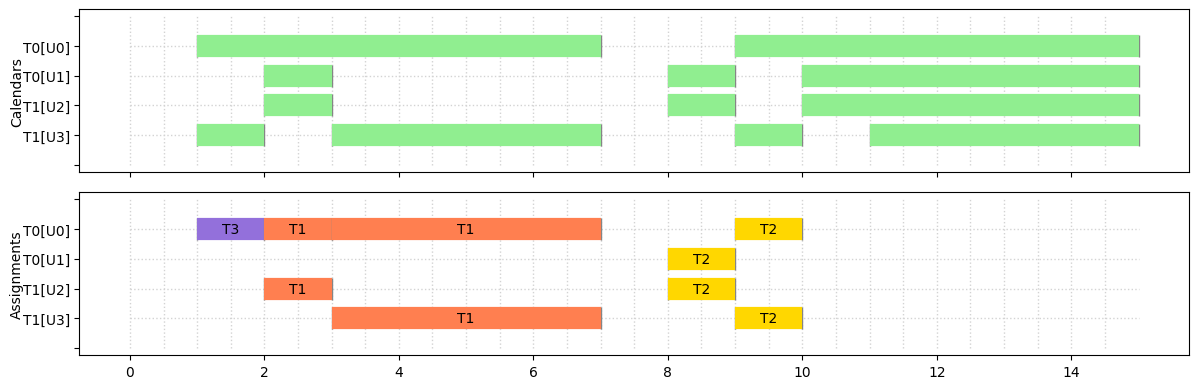

In [24]:
visualize_schedule(sol, RES_MAP, R, TYPES, assignments=task_assignments, origin=0, horizon=12)

### OptalCP Implementation

In [25]:
import optalcp as cp

res_types = prepare_types(TYPES)
res_breaks = extract_breaks(UNITS)

mdl = cp.Model(name="migration_no_delays")

# (5) T_i: mandatory interval var with fixed length d_i
T = {i: mdl.interval_var(length=size, name=f"T{i}") for i, size, _ in TASKS}

# (1) Objective: minimize makespan
mdl.minimize(mdl.max([T[i].end() for i in range(N)]))

# (2) Precedences
mdl.add([T[i].end_before_start(T[j]) for i, j in PRECEDENCES])

# (3) + (4) Aggregated resource capacity: usage <= capacity - breaks
for type_id, rtype in res_types.items():
    usage = mdl.sum([mdl.pulse(T[i], qty) 
                     for i, _, reqs in TASKS 
                     for req_type, qty in reqs 
                     if req_type == type_id and qty > 0])
    
    breaks = mdl.sum([mdl.pulse(mdl.interval_var(start=(s, s), end=(s+d, s+d)), 1)
                      for u in rtype["units"] if u in res_breaks 
                      for s, d in res_breaks[u]])
    
    mdl.add(usage + breaks <= rtype["capacity"])

# Solve
print("Solving Migration | No Delays...")
result = mdl.solve(cp.Parameters(timeLimit=10))

if result.solution:
    sol = result.solution
    print(f"\n{'='*60}\n✓ Makespan: {result.objective_value}\n{'='*60}")
    print(f"{'Task':<6}{'Start':<8}{'End':<8}{'Duration'}")
    print("-" * 60)
    for i in sorted(T.keys()):
        print(f"T{i:<5}{sol.get_start(T[i]):<8}{sol.get_end(T[i]):<8}{sol.get_end(T[i]) - sol.get_start(T[i])}")
else:
    print("No solution found.")

Solving Migration | No Delays...
--------------------------------------------------------------------------------
                         ScheduleOpt OptalCP [Academic]
                           Version 2025.11.1 (Linux)
                CPU: AMD Ryzen 5 5500U with (12 physical cores)
--------------------------------------------------------------------------------
Input parse time: 00:00
Parameters:
   TimeLimit = 10 seconds
Input: migration_no_delays
   0 integer variables, 21 interval variables, 8 constraints, 15.8kB
   00:00 Presolving..
Presolved:
   0 integer variables, 21 interval variables, 8 constraints, 15.8kB
   00:00 Starting the search using 12 workers (physical cores count).
--------------------------------------------------------------------------------
   00:00 Lower bound 6 Worker 0
   00:00 Solution 13 Worker 5: LNS
   00:00 Solution 10 Worker 5: LNS
   00:00 Lower bound 10 Worker 5: Optimality proof
   00:00 Worker 5: The current best solution is optimal.
-----------

## 3. No Migration | Delays | Blocked

### Problem Definiton

We consider a project scheduling problem with a set of tasks $\mathcal{N}$ having fixed processing durations and subject to finish-to-start precedence relations $\mathcal{E}$.
Each task $i$ defines its requirements in terms of resource units quantities of various resource types. For example, a task might require "2 Electricians and 1 Plumber". To fulfill these requirements, the task must be assigned to exactly one feasible team composition, known as a mode ($m \in \mathcal{M}_i$). Each mode $m$ specifies a concrete set of resource units $\mathcal{R}_{i,m}$ that satisfy the task's resource type requirements. Continuing the example, a specific mode might assign the resource unit "John" (who belongs to resource type "Electrician"), the resource unit "Mary" (who also belongs to resource type "Electrician"), and the resource unit "Steve" (who belongs to resource type "Plumber"). Each resource unit $r$ operates according to its own availability calendar $\mathcal{F}_r(t) \in \{0, 1\}$. When a task requires multiple resource units, all assigned units must be available simultaneously. If resource unit John has a calendar-based day off, the task progress pauses, and resource units Mary and Steve remain blocked and unavailable to other tasks, even if their own calendars show they are available.

### CP Formulation

$$
\begin{aligned}
\min \quad
& \max_{i \in \mathcal{N}} (\operatorname{end}(T_i))
\qquad &\qquad & \text{(1)} \\[2mm]
\text{s.t.} \quad
& \operatorname{endBeforeStart}(T_i, T_j),
\qquad & \forall (i, j) \in \mathcal{E}
\quad & \text{(2)} \\[2mm]
& \operatorname{alternative}(T_i, \{O_{i,m} \mid m \in \mathcal{M}_i\}),
\qquad & \forall i \in \mathcal{N}
\quad & \text{(3)} \\[2mm]
& \operatorname{noOverlap}(\{O_{i,m} \mid i \in \mathcal{N}, m \in \mathcal{M}_i: r \in \mathcal{R}_{i,m}\}),
\qquad & \forall r \in \mathcal{R}
\quad & \text{(4)} \\[2mm]
& \operatorname{sizeOf}(O_{i,m}) = \int_{\operatorname{start}(O_{i,m})}^{\operatorname{end}(O_{i,m})} \mathcal{G}_{i,m}(t) \, dt,
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i
\quad & \text{(5)} \\[2mm]
& \operatorname{forbidStart}(O_{i,m}, \mathcal{G}_{i,m}),
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i
\quad & \text{(6)} \\[2mm]
& \mathcal{G}_{i,m}(t) = \min_{r \in \mathcal{R}_{i,m}} (\mathcal{F}_r(t)),
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i
\quad & \text{(7)} \\[2mm]
& T_i: \text{mandatory interval var},
\qquad & \forall i \in \mathcal{N}
\quad & \text{(8a)} \\[1mm]
& O_{i,m}: \text{optional interval var}, \text{ intensity } \mathcal{G}_{i,m},
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i
\quad & \text{(8b)}
\end{aligned}
$$

**Objective**
* **(1)** Minimize the project completion time.

**Modeling Constraints**
* **(2)** Precedence relations - standard finish-to-start dependencies.
* **(3)** The alternative constraint forces the solver to select exactly one valid combination of resource units (Mode $m$) for task $i$. It strictly synchronizes the Master Task $T_i$ with the selected Mode Interval $O_{i,m}$. (Modes can consist of multiple resource units of multiple resource types)
* **(4)** For each resource unit $r$: create a noOverlap constraint containing all intervals $O_{i,m}$ whose mode $m$ uses this resource unit $r$. 
* **(5)** Calendar-based blocking: work accumulates only when joint intensity $\mathcal{G}_{i,m} = 1$ (all assigned units available). When any unit is unavailable, work pauses but all assigned units remain blocked.
* **(6)** Forbid start during unavailability: tasks cannot start when $\mathcal{G}_{i,m}(t) = 0$.

Note: Constraint (6) does not affect makespan but ensures consistency—no idle time at task start.

**Variables and Functions**
* **(7)** $\mathcal{G}_{i,m}(t)$: joint intensity function — equals 100 only when all units in mode $m$ are available at time $t$, otherwise 0.
* **(8a)** $T_i$: master interval variable for task $i$.
* **(8b)** $O_{i,m}$: optional mode interval with intensity $\mathcal{G}_{i,m}$.

**Parameters**
* $\mathcal{N}$: et of tasks to be scheduled.
* $\mathcal{E}$: Set of precedence relations (finish-to-start dependencies)
* $\mathcal{R}$: set of all resource units of all resource types.
* $\mathcal{M}_i$: set of valid modes (resource unit combinations) for task $i$.
* $\mathcal{R}_{i,m}$: resource units assigned in mode $m$ of task $i$.
* $\mathcal{F}_r(t) \in \{0, 1\}$: Availability calendar (step function) for resource unit $r$ at time $t$.

### IBM CPO DOcplex Implementation

#### Prepare Data

In [26]:
task_modes = build_modes(TASKS, TYPE_MAP)

In [27]:
task_modes

{0: [()],
 1: [(0, 2), (0, 3), (1, 2), (1, 3)],
 2: [(0, 2), (0, 3), (1, 2), (1, 3)],
 3: [(0,), (1,)],
 4: [()]}

#### Create model and variables

In [28]:
mdl = CpoModel(name="preemptive_delays_nomigration_cpo")

In [29]:
# (7) G_{i,m}(t) = min(F_r(t)) - joint intensity functions
joint_intensities = {
    (i, m): joint_intensity(m, RES_MAP)
    for i in task_modes for m in task_modes[i]
}

# (5) + (8b) O_{i,m}: optional interval var with intensity G_{i,m}
mode_intervals = {
    (i, m): interval_var(size=size, intensity=joint_intensities[(i, m)],
                              optional=True, name=f"T{i}_Mode_{m}")
    for i, size, _ in TASKS for m in task_modes[i]
}

# (8a) T_i: mandatory interval var (with no size)
T = {i: interval_var(name=f"T{i}") for i, _, _ in TASKS}

#### Add constraints and define objective

In [30]:
# (1) Objective: minimize makespan
mdl.add(minimize(mdl.max([end_of(T[i]) for i in range(N)])))

In [31]:
# (2) Precedences: endBeforeStart(T_i, T_j)
mdl.add([end_before_start(T[i], T[j]) for i, j in PRECEDENCES])

# (3) Alternative: mode selection & synchronization
for i in T:
    if modes := [int_var for (t, m), int_var in mode_intervals.items() if t == i]:
        mdl.add(alternative(T[i], modes))

# (4) Resource capacity: noOverlap per resource
for r in range(R):
    if intervals := [int_var for (t, m), int_var in mode_intervals.items() if r in m]:
        mdl.add(no_overlap(intervals))

# (6) Forbid start during unavailability
for (i, m), int_var in mode_intervals.items():
    mdl.add(forbid_start(int_var, joint_intensities[(i, m)]))

#### Solve the model

In [32]:
print("Solving...")
if sol := mdl.solve(LogVerbosity='Quiet'):
    print_solution(sol, T, mode_intervals, N)

Solving...

✓ SOLUTION - Makespan: 10
Task  Start End   Dur  Resources
---------------------------------------------------------------------------
T0    0     0     0    {U()}
T1    1     7     6    {U(0, 3)}
T2    2     9     7    {U(1, 2)}
T3    9     10    1    {U(0,)}
T4    10    10    0    {U()}



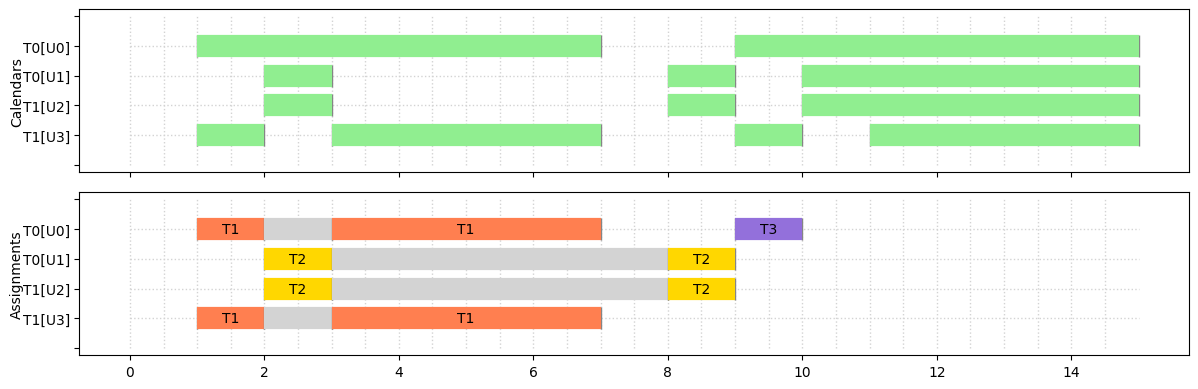

In [33]:
visualize_schedule(sol, RES_MAP, R, TYPES, mode_intervals=mode_intervals, origin=0, horizon=12)

### OptalCP Implementation

In [35]:
import optalcp as cp

task_modes = build_modes(TASKS, TYPE_MAP)

# Helper: compute joint intensity steps directly
def joint_intensity_steps(unit_ids, res_map, horizon=HORIZON):
    """Returns [(time, value), ...] where value=1 when ALL units available, else 0."""
    if not unit_ids:
        return [(0, 1)]  # Always available if no units required
    times = sorted({0} | {t for uid in unit_ids if uid in res_map for t, _ in res_map[uid]})
    if not times:
        return [(0, 1)]
    return [(t, 1 if all(get_availability(u, t, res_map) > 0 for u in unit_ids) else 0) for t in times]

mdl = cp.Model(name="no_migration_delays_blocked")

# (7) G_{i,m}: joint intensity step functions (only for non-empty modes)
joint_intensities = {}
for i in task_modes:
    for m in task_modes[i]:
        steps = joint_intensity_steps(m, RES_MAP)
        if steps:
            joint_intensities[(i, m)] = mdl.step_function(steps)

# (8a) T_i: mandatory master interval
T = {i: mdl.interval_var(name=f"T{i}") for i, _, _ in TASKS}

# (8b) O_{i,m}: optional mode interval
O = {(i, m): mdl.interval_var(optional=True, name=f"T{i}_M{m}")
     for i in task_modes for m in task_modes[i]}

# (1) Objective: minimize makespan
mdl.minimize(mdl.max([T[i].end() for i in range(N)]))

# (2) Precedences
mdl.add([T[i].end_before_start(T[j]) for i, j in PRECEDENCES])

# (3) Alternative: select exactly one mode per task
for i in T:
    modes_for_task = [O[(i, m)] for m in task_modes[i]]
    if modes_for_task:
        mdl.add(mdl.alternative(T[i], modes_for_task))

# (4) NoOverlap per resource unit
for r in range(R):
    intervals = [O[(i, m)] for (i, m) in O if r in m]
    if intervals:
        mdl.add(mdl.no_overlap(intervals))

# (5) Work content: size = integral of intensity over interval
for i, size, _ in TASKS:
    if size > 0:
        for m in task_modes[i]:
            if (i, m) in joint_intensities:
                work = mdl.step_function_sum(joint_intensities[(i, m)], O[(i, m)])
                mdl.add(mdl.implies(O[(i, m)].presence(), work == size))

# (6) Forbid start during unavailability (only for non-empty modes with step functions)
for (i, m), itv in O.items():
    if (i, m) in joint_intensities and m:  # Only if mode has units
        mdl.add(itv.forbid_start(joint_intensities[(i, m)]))

# Solve
print("Solving No Migration | Delays | Blocked...")
try:
    result = mdl.solve(cp.Parameters(timeLimit=10))
    
    if result.solution:
        sol = result.solution
        print(f"\n{'='*70}\n✓ Makespan: {result.objective_value}\n{'='*70}")
        print(f"{'Task':<6}{'Start':<8}{'End':<8}{'Mode (Units)'}")
        print("-" * 70)
        for i in sorted(T.keys()):
            selected = next((m for m in task_modes[i] if sol.is_present(O[(i, m)])), None)
            mode_str = "{" + ",".join(f"U{r}" for r in selected) + "}" if selected else "—"
            print(f"T{i:<5}{sol.get_start(T[i]):<8}{sol.get_end(T[i]):<8}{mode_str}")
    else:
        print("No solution found.")
except Exception as e:
    print(f"Solver error: {e}")
    # Debug: print what step functions look like
    print("\nDebug - Step functions created:")
    for (i, m) in list(joint_intensities.keys())[:5]:
        print(f"  Task {i}, Mode {m}: {joint_intensity_steps(m, RES_MAP)}")

Solving No Migration | Delays | Blocked...
--------------------------------------------------------------------------------
                         ScheduleOpt OptalCP [Academic]
                           Version 2025.11.1 (Linux)
                CPU: AMD Ryzen 5 5500U with (12 physical cores)
--------------------------------------------------------------------------------
Input parse time: 00:00
Parameters:
   TimeLimit = 10 seconds
Input: no_migration_delays_blocked
   0 integer variables, 17 interval variables, 35 constraints, 21.2kB
   00:00 Presolving..
Solver error: Solver closed unexpectedly without sending results

Debug - Step functions created:
  Task 0, Mode (): [(0, 1)]
  Task 1, Mode (0, 2): [(0, 0), (1, 0), (2, 1), (3, 0), (7, 0), (8, 0), (9, 0), (10, 1), (15, 0)]
  Task 1, Mode (0, 3): [(0, 0), (1, 1), (2, 0), (3, 1), (7, 0), (9, 1), (10, 0), (11, 1), (15, 0)]
  Task 1, Mode (1, 2): [(0, 0), (2, 1), (3, 0), (8, 1), (9, 0), (10, 1), (15, 0)]
  Task 1, Mode (1, 3): [(0, 

## 4. Migration | Delays

Tasks can be interrupted when aggregate resource capacity drops below requirements. With migration, tasks are not locked to specific resource units—they can use any available units of the required type. When capacity is insufficient, the task pauses; when capacity returns, it resumes (potentially on different units).

### CP Formulation

$$
\begin{aligned}
\min \quad
& \max_{i \in \mathcal{N}} (\operatorname{end}(T_i))
& & \text{ (1)} \\[2mm]
\text{s.t.} \quad
& \operatorname{endBeforeStart}(T_i, T_j),
& \forall (i, j) \in \mathcal{E}
& \text{ (2)} \\[2mm]
& \operatorname{span}(T_i, \{S_{i,w} \mid w \in \mathcal{W}_i\}),
& \forall i \in \mathcal{N}
& \text{ (3)} \\[2mm]
& \sum_{w \in \mathcal{W}_i} \operatorname{sizeOf}(S_{i,w}) = d_i,
& \forall i \in \mathcal{N}
& \text{ (4)} \\[2mm]
& S_{i,w} \subseteq [w^s, w^e),
& \forall i \in \mathcal{N}, \forall w \in \mathcal{W}_i
& \text{ (5)} \\[2mm]
& \sum_{i \in \mathcal{N}} \sum_{w \in \mathcal{W}_i} \operatorname{pulse}(S_{i,w}, q_{i,k}) \leq A_k,
& \forall k \in \mathcal{K}
& \text{ (6)} \\[2mm]
& A_k(t) = \sum_{r \in \mathcal{U}_k} \mathcal{F}_r(t),
& \forall k \in \mathcal{K}
& \text{ (7)} \\[2mm]
& \mathcal{W}_i = \{[w^s, w^e) \mid A_k(t) \geq q_{i,k}, \forall k \in \mathcal{K}_i, \forall t \in [w^s, w^e)\},
& \forall i \in \mathcal{N}
& \text{ (8)} \\[2mm]
& T_i: \text{mandatory interval var}
& \forall i \in \mathcal{N}
& \text{ (9a)} \\[1mm]
& S_{i,w}: \text{optional interval var}
& \forall i \in \mathcal{N}, \forall w \in \mathcal{W}_i
& \text{ (9b)}
\end{aligned}
$$

**Objective**
* **(1)** Minimize makespan (project completion time).

**Constraints**
* **(2)** Precedence: finish-to-start dependencies between tasks.
* **(3)** Span: master interval $T_i$ spans all its active segments $S_{i,w}$.
* **(4)** Work content: total work across all segments equals required duration $d_i$.
* **(5)** Window containment: each segment must stay within its capacity window boundaries.
* **(6)** Aggregate capacity: pulse constraints on segments prevent over-allocation per resource type.

**Variables and Functions**
* **(7)** $A_k(t)$: aggregate availability for resource type $k$ — sum of individual unit availabilities at time $t$.
* **(8)** $\mathcal{W}_i$: capacity windows — pre-computed maximal intervals where aggregate capacity satisfies all of task $i$'s requirements.
* **(9a)** $T_i$: master interval variable for task $i$.
* **(9b)** $S_{i,w}$: optional segment interval for task $i$ within capacity window $w$.

**Parameters**
* $\mathcal{N}$: set of tasks.
* $\mathcal{E}$: precedence relations (finish-to-start).
* $\mathcal{K}$: set of resource types.
* $\mathcal{K}_i \subseteq \mathcal{K}$: resource types required by task $i$.
* $\mathcal{U}_k$: resource units belonging to resource type $k$.
* $q_{i,k}$: quantity of resource type $k$ required by task $i$.
* $d_i$: processing duration (work content) of task $i$.
* $\mathcal{F}_r(t) \in \{0, 1\}$: availability calendar for unit $r$.

### IBM CPO DOcplex Implementation

#### Prepare Data

In [ ]:
res_types = prepare_types(TYPES)
res_breaks = extract_breaks(UNITS)

for i, size, reqs in TASKS:
    print(f"T{i} (needs {reqs}): {capacity_windows(reqs, TYPE_MAP, RES_MAP)}")

T0 (needs [(0, 0), (1, 0)]): [(0, 100000)]
T1 (needs [(0, 1), (1, 1)]): [(1, 7), (8, 15)]
T2 (needs [(0, 1), (1, 1)]): [(1, 7), (8, 15)]
T3 (needs [(0, 1)]): [(1, 7), (8, 15)]
T4 (needs [(0, 0), (1, 0)]): [(0, 100000)]


#### Create model and variables

In [ ]:
mdl = CpoModel(name="preemptive_withdelays_migration_segments")

# (8) Pre-compute capacity windows for each task
task_windows = {i: capacity_windows(reqs, TYPE_MAP, RES_MAP) 
                for i, size, reqs in TASKS}

# (9a) Master interval for each task
T = {i: interval_var(name=f"T{i}") for i, size, _ in TASKS}

# (9b) + (5) Optional segment intervals, constrained to stay within their capacity window 
segments = {(i, w): interval_var(optional=True, start=(s, e-1), end=(s+1, e), name=f"T{i}_seg{w}")
            for i in task_windows for w, (s, e) in enumerate(task_windows[i])}

#### Add constraints and define objective

In [ ]:
# (1) objective: minimize makespan
mdl.add(minimize(max(end_of(T[i]) for i in T)))

In [ ]:
# (2) precedences
mdl.add([end_before_start(T[i], T[j]) for i, j in PRECEDENCES])

# (3) span: master interval spans all its segments
for i, _, _ in TASKS:
    if segs := [segments[(i, w)] for w in range(len(task_windows[i]))]:
        mdl.add(span(T[i], segs))

# (4) sum of segment sizes = required duration
for i, size, _ in TASKS:
    if size > 0:
        mdl.add(sum(size_of(segments[(i, w)], 0) for w in range(len(task_windows[i]))) == size)

# (6) Cumulative capacity using segments
A = {k: step_at(0, rt["capacity"]) - sum(pulse((s, s+d), 1) 
     for u in rt["units"] if u in res_breaks for s, d in res_breaks[u])
     for k, rt in res_types.items()}
for k in res_types:
    if pulses := [pulse(segments[(i, w)], q) for i, _, reqs in TASKS 
             for rk, q in reqs if q > 0 and rk == k for w in range(len(task_windows[i]))]:
        mdl.add(A[k] - sum(pulses) >= 0)

#### Solve the model

In [ ]:
print("Solving Preemptive (With Delays) | Migration (Segment Model)...")
sol = mdl.solve(LogVerbosity='Quiet')

Solving Preemptive (With Delays) | Migration (Segment Model)...


In [ ]:
if sol:
    sep = '='*75
    print(f"\n{sep}\n✓ SOLUTION - Makespan: {sol.get_objective_values()[0]}\n{sep}\n{'Task':<5} {'Start':<5} {'End':<5} {'Size':<5} {'Segments'}\n{'-'*75}")
    for i in sorted(T):
        t = sol.get_var_solution(T[i])
        segs = [s for s in (sol.get_var_solution(segments[(i, w)]) 
                for w in range(len(task_windows[i]))) if s and s.is_present()]
        print(f"T{i:<4} {t.get_start():<5} {t.get_end():<5} {sum(s.get_size() for s in segs):<5} {', '.join(f'[{s.get_start()}-{s.get_end()})' for s in segs) or '—'}")
    print(f"{sep}\n")
else:
    print("No solution found.")


✓ SOLUTION - Makespan: 9
Task  Start End   Size  Segments
---------------------------------------------------------------------------
T0    0     1     1     [0-1)
T1    1     9     5     [1-5), [8-9)
T2    5     9     2     [5-7), [9-9)
T3    2     9     1     [2-3), [9-9)
T4    9     9     0     [9-9)



#### Resource Unit Assignment (Post-Processing)

In [ ]:
task_assignments = extract_segments(
    sol, segments, task_windows, TASKS, TYPE_MAP, RES_MAP)

print("Resource Unit Assignments (with delays and migration):")
for i in sorted(task_assignments):
    print(f"  T{i}: {', '.join(f'{{{','.join(f'U{r}' for r in res)}}}@[{s}-{e})' for s, e, res in task_assignments[i]) or '—'}")

Resource Unit Assignments (with delays and migration):
  T0: —
  T1: {U0,U3}@[1-2), {U0,U2}@[2-3), {U0,U3}@[3-5), {U1,U2}@[8-9)
  T2: {U0,U3}@[5-7)
  T3: {U1}@[2-3)
  T4: —


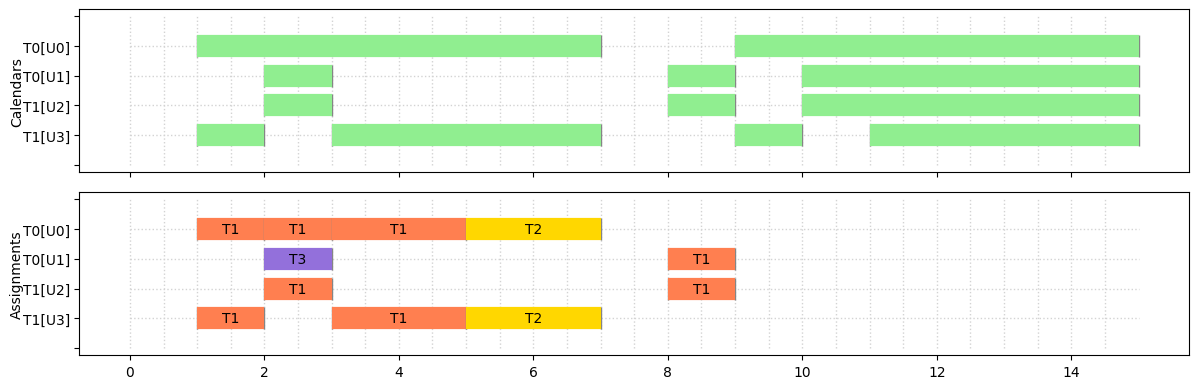

In [ ]:
visualize_schedule(sol, RES_MAP, R, TYPES, assignments=task_assignments, origin=0, horizon=12)

### OptalCP Implementation

In [ ]:
import optalcp as cp

res_types = prepare_types(TYPES)
res_breaks = extract_breaks(UNITS)

# (8) Pre-compute capacity windows for each task
task_windows = {i: capacity_windows(reqs, TYPE_MAP, RES_MAP) for i, _, reqs in TASKS}

mdl = cp.Model(name="migration_delays")

# (9a) T_i: master interval
T = {i: mdl.interval_var(name=f"T{i}") for i, _, _ in TASKS}

# (9b) + (5) S_{i,w}: optional segment intervals within capacity windows
S = {(i, w): mdl.interval_var(optional=True, start=(s, e-1), end=(s+1, e), name=f"T{i}_seg{w}")
     for i in task_windows for w, (s, e) in enumerate(task_windows[i])}

# (1) Objective: minimize makespan
mdl.minimize(mdl.max([T[i].end() for i in T]))

# (2) Precedences
mdl.add([T[i].end_before_start(T[j]) for i, j in PRECEDENCES])

# (3) Span: master interval spans all its segments
for i, _, _ in TASKS:
    segs = [S[(i, w)] for w in range(len(task_windows[i]))]
    if segs:
        mdl.add(mdl.span(T[i], segs))

# (4) Work content: sum of segment lengths = task duration
for i, size, _ in TASKS:
    if size > 0:
        mdl.add(mdl.sum([S[(i, w)].length().guard(0) for w in range(len(task_windows[i]))]) == size)

# (6) Cumulative capacity on segments
for type_id, rtype in res_types.items():
    usage = mdl.sum([mdl.pulse(S[(i, w)], qty) 
                     for i, _, reqs in TASKS 
                     for req_type, qty in reqs if req_type == type_id and qty > 0
                     for w in range(len(task_windows[i]))])
    
    breaks = mdl.sum([mdl.pulse(mdl.interval_var(start=(s, s), end=(s+d, s+d)), 1)
                      for u in rtype["units"] if u in res_breaks 
                      for s, d in res_breaks[u]])
    
    mdl.add(usage + breaks <= rtype["capacity"])

# Solve
print("Solving Migration | Delays...")
result = mdl.solve(cp.Parameters(timeLimit=10))

if result.solution:
    sol = result.solution
    print(f"\n{'='*75}\n✓ Makespan: {result.objective_value}\n{'='*75}")
    print(f"{'Task':<6}{'Start':<8}{'End':<8}{'Segments'}")
    print("-" * 75)
    for i in sorted(T.keys()):
        segs = [(sol.get_start(S[(i, w)]), sol.get_end(S[(i, w)])) 
                for w in range(len(task_windows[i])) if sol.is_present(S[(i, w)])]
        seg_str = ", ".join(f"[{s}-{e})" for s, e in segs) if segs else "—"
        print(f"T{i:<5}{sol.get_start(T[i]):<8}{sol.get_end(T[i]):<8}{seg_str}")
else:
    print("No solution found.")

Solving Migration | Delays...
--------------------------------------------------------------------------------
                         ScheduleOpt OptalCP [Academic]
                           Version 2025.11.1 (Linux)
                CPU: AMD Ryzen 5 5500U with (12 physical cores)
--------------------------------------------------------------------------------
Input parse time: 00:00
Parameters:
   TimeLimit = 10 seconds
Input: migration_delays
   0 integer variables, 29 interval variables, 16 constraints, 20.2kB
   00:00 Presolving..
Presolved:
   0 integer variables, 27 interval variables, 14 constraints, 19.3kB
   00:00 Starting the search using 12 workers (physical cores count).
--------------------------------------------------------------------------------
   00:00 Lower bound 2 Worker 5
   00:00 Solution 13 Worker 4: LNS
   00:00 Solution 12 Worker 4: LNS
   00:00 Solution 10 Worker 4: LNS
   00:00 Solution 9 Worker 4: LNS
   00:00 Lower bound 9 Worker 4: Optimality proof
   0

## 5. Multi-Resource Heterogeneous Policy

No Migration | No Delays + Migration policy | No Delays

This problem models scenarios where different resource types follow different scheduling policies within the same project. Fixed resource types (eg. machine) follow a **No Migration | No Delays** policy: once a task is assigned to a specific machine, it must execute continuously on that same machine without interruption, and the task must fit entirely within the machine's availability window. Migration resource type (eg. workers) follow a **Migration policy | No Delays**: tasks can freely switch between available workers during execution, and as long as enough workers are available in aggregate, the task continues without pause. 

$$
\begin{aligned}
\min \quad
& \max_{i \in \mathcal{N}} (\operatorname{end}(T_i))
& & \text{ (1)} \\[2mm]
\text{s.t.} \quad
& \operatorname{endBeforeStart}(T_i, T_j),
& \forall (i, j) \in \mathcal{E}
& \text{ (2)} \\[2mm]
& \operatorname{alternative}(T_i, \{O_{i,r} \mid r \in \mathcal{U}_k\}, q_{i,k}),
& \forall i \in \mathcal{N}, \forall k \in \mathcal{K}_i^{fix}
& \text{ (3)} \\[2mm]
& \operatorname{noOverlap}(\{O_{i,r} \mid i \in \mathcal{N}, r \in \mathcal{C}_i^{fix}\}),
& \forall r \in \bigcup_{k \in \mathcal{K}^{fix}} \mathcal{U}_k
& \text{ (4)} \\[2mm]
& \operatorname{forbidExtent}(O_{i,r}, \overline{\mathcal{F}_r}),
& \forall i \in \mathcal{N}, \forall r \in \mathcal{C}_i^{fix}
& \text{ (5)} \\[2mm]
& \sum_{i \in \mathcal{N}} \operatorname{pulse}(T_i, q_{i,k}) \leq A_k,
& \forall k \in \mathcal{K}^{mig}
& \text{ (6)} \\[2mm]
& A_k(t) = \sum_{r \in \mathcal{U}_k} \mathcal{F}_r(t),
& \forall k \in \mathcal{K}^{mig}
& \text{ (7)} \\[2mm]
& T_i: \text{mandatory interval var with size } d_i
& \forall i \in \mathcal{N}
& \text{ (8a)} \\[1mm]
& O_{i,r}: \text{optional interval var with size } d_i
& \forall i \in \mathcal{N}, \forall r \in \mathcal{C}_i^{fix}
& \text{ (8b)}
\end{aligned}
$$

**Objective**
* **(1)** Minimize makespan (project completion time).

**Constraints**
* **(2)** Precedence: finish-to-start dependencies between tasks.
* **(3)** Fixed-type unit selection: for each fixed resource type requirement, select exactly $q_{i,k}$ resrouce units via alternative with cardinality.
* **(4)** Fixed-type capacity: each resource unit can execute at most one task at a time. Iterate over all resource units $r$ of all fixed resource types $k$.
* **(5)** Fixed-type calendar: resource unit intervals must respect availability windows.
* **(6)** Migration-type capacity: aggregate demand must not exceed available capacity $A_k(t)$ at any time for all migration resource type $k$.

**Variables and Functions**
* **(7)** $A_k(t)$: aggregate availability for migration resource type $k$ — sum of resource unit availabilities at time $t$.
* **(8a)** $T_i$: master interval with fixed size $d_i$.
* **(8b)** $O_{i,r}$: optional interval for task $i$ on fixed type resource unit $r$.

**Parameters**
* $\mathcal{N}$: set of tasks.
* $\mathcal{E}$: precedence relations (finish-to-start).
* $\mathcal{K}^{fix}$: resource types requiring fixed assignment (no migration).
* $\mathcal{K}^{mig}$: resource types allowing migration.
* $\mathcal{K}_i^{fix}$: fixed resource types required by task $i$.
* $\mathcal{U}_k$: resource units belonging to resource type $k$.
* $\mathcal{C}_i^{fix} = \bigcup_{k \in \mathcal{K}_i^{fix}} \mathcal{U}_k$: candidate resource units for task $i$ across all its fixed resource type requirements.
* $q_{i,k}$: quantity of resource type $k$ required by task $i$.
* $d_i$: processing duration of task $i$.
* $\mathcal{F}_r(t) \in \{0, 1\}$: availability calendar for resource unit $r$.
* $\overline{\mathcal{F}_r}$: complement (unavailability periods).
  
Fixed types use explicit unit assignment (alternative + noOverlap + forbidExtent), migration types use aggregate capacity (pulse).

### IBM CPO DOcplex Implementation

#### Prepare Data

In [ ]:
res_types = prepare_types(TYPES)
res_breaks = extract_breaks(UNITS)

# Define which types allow migration vs fixed assignment
FIXED_TYPES = {0}      # No migration - use alternative constraint
MIGRATION_TYPES = {1}  # Migration allowed - use pulse constraint

# F_r: Availability functions for fixed types (used in constraint 5)
res_availability = {r: step_function(steps) for r, steps in UNITS
                    if any(r in TYPE_MAP[k] for k in FIXED_TYPES)}

#### Create Model and Variables

In [ ]:
mdl = CpoModel(name="heterogeneous_policy")

# (8a) Master intervals
T = {i: interval_var(size=size, name=f"T{i}") for i, size, _ in TASKS}

# (8b) Unit intervals only for fixed types
O = {(i, r): interval_var(size=size, optional=True, name=f"T{i}_U{r}")
     for i, size, reqs in TASKS for k, q in reqs if k in FIXED_TYPES and q > 0 for r in TYPE_MAP[k]}

# (7) A_k(t): Capacity functions for migration types
A = {k: step_at(0, rt["capacity"]) - sum(pulse((s, s+d), 1) 
     for u in rt["units"] if u in res_breaks for s, d in res_breaks[u])
     for k, rt in res_types.items() if k in MIGRATION_TYPES}

#### Add Constraints and Define Objective

In [ ]:
# (1) Objective: minimize makespan
mdl.add(minimize(max(end_of(T[i]) for i in T)))

In [ ]:
# (2) Precedences
mdl.add([end_before_start(T[i], T[j]) for i, j in PRECEDENCES])

# (3) Alternative for fixed types: select specific units
for i, _, reqs in TASKS:
    for k, q in reqs:
        if k in FIXED_TYPES and q > 0:
            mdl.add(alternative(T[i], [O[(i, r)] for r in TYPE_MAP[k]], cardinality=q))

# (4) No overlap per unit for fixed types
for k in FIXED_TYPES:
    for r in TYPE_MAP[k]:
        if int_vars := [itv for (_, uid), itv in O.items() if uid == r]:
            mdl.add(no_overlap(int_vars))

# (5) Calendar compliance for fixed types
for (i, r), int_var in O.items():
    if r in res_availability:
        mdl.add(forbid_extent(int_var, res_availability[r]))

# (6) Aggregate capacity for migration types
for k in MIGRATION_TYPES:
    if pulse := [pulse(T[i], q) for i, _, reqs in TASKS for rk, q in reqs if rk == k and q > 0]:
        mdl.add(A[k] - sum(pulse) >= 0)

#### Solve the model

In [ ]:
print("Solving Heterogeneous Policy...")
sol = mdl.solve(LogVerbosity='Quiet')

Solving Heterogeneous Policy...


In [ ]:
if sol:
    print(f"\n{'='*75}\n✓ SOLUTION - Makespan: {sol.get_objective_values()[0]}\n{'='*75}")
    print(f"{'Task':<5} {'Start':<5} {'End':<5} {'Fixed Units':<20} {'Migration Types'}\n{'-'*75}")
    
    for i, _, reqs in TASKS:
        if t := sol.get_var_solution(T[i]):
            fixed = [r for (ti, r), itv in O.items() if ti == i and (s := sol.get_var_solution(itv)) and s.is_present()]
            mig = [(k, q) for k, q in reqs if k in MIGRATION_TYPES and q > 0]
            f_str = "{" + ",".join(f"U{r}" for r in sorted(fixed)) + "}" if fixed else "—"
            m_str = ", ".join(f"{q}×T{k}" for k, q in mig) if mig else "—"
            print(f"T{i:<4} {t.get_start():<5} {t.get_end():<5} {f_str:<20} {m_str}")
    print(f"{'='*75}\n")
else:
    print("No solution found.")


✓ SOLUTION - Makespan: 11
Task  Start End   Fixed Units          Migration Types
---------------------------------------------------------------------------
T0    0     0     —                    —
T1    1     6     {U0}                 1×T1
T2    9     11    {U0}                 1×T1
T3    6     7     {U0}                 —
T4    11    11    —                    —



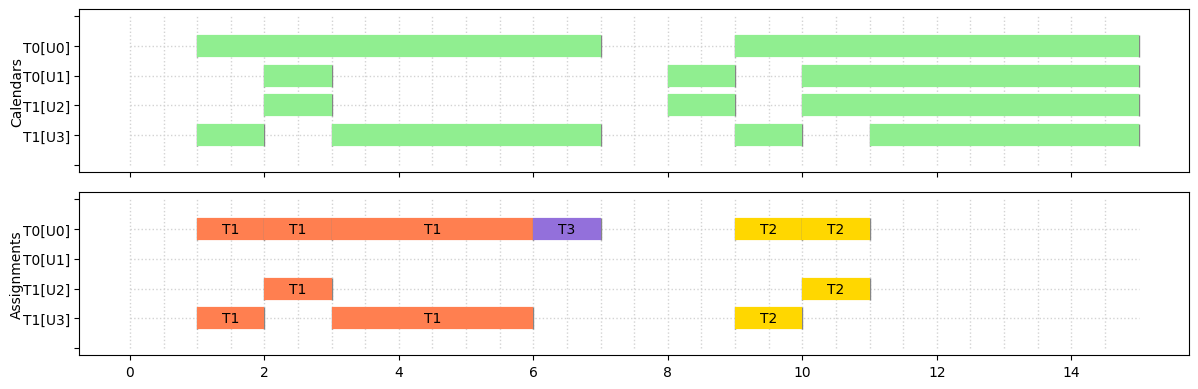

In [ ]:
task_assignments = extract_heterogeneous(sol, T, TASKS, TYPE_MAP, RES_MAP, O, FIXED_TYPES, MIGRATION_TYPES)
visualize_schedule(sol, RES_MAP, R, TYPES, assignments=task_assignments, origin=0, horizon=12)

### OptalCP Implementation

In [ ]:
import optalcp as cp

FIXED_TYPES = {0}      # No migration
MIGRATION_TYPES = {1}  # Migration allowed

res_types = prepare_types(TYPES)
res_breaks = extract_breaks(UNITS)

mdl = cp.Model(name="heterogeneous_policy")

# (8a) T_i: master interval with fixed length
T = {i: mdl.interval_var(length=size, name=f"T{i}") for i, size, _ in TASKS}

# (8b) O_{i,r}: unit intervals for FIXED types only
O = {(i, r): mdl.interval_var(length=size, optional=True, name=f"T{i}_U{r}")
     for i, size, reqs in TASKS 
     for k, q in reqs if k in FIXED_TYPES and q > 0 
     for r in TYPE_MAP[k]}

# F_r: availability step functions for fixed types
res_availability = {r: mdl.step_function(steps) for r, steps in UNITS 
                    if any(r in TYPE_MAP.get(k, []) for k in FIXED_TYPES)}

# (1) Objective
mdl.minimize(mdl.max([T[i].end() for i in T]))

# (2) Precedences
mdl.add([T[i].end_before_start(T[j]) for i, j in PRECEDENCES])

# (3) Fixed types: select units with cardinality + synchronization
for i, size, reqs in TASKS:
    for k, q in reqs:
        if k in FIXED_TYPES and q > 0:
            candidates = [O[(i, r)] for r in TYPE_MAP[k]]
            mdl.add(mdl.sum([itv.presence() for itv in candidates]) == q)
            mdl.add([T[i].start_at_start(itv) for itv in candidates])
            mdl.add([T[i].end_at_end(itv) for itv in candidates])

# (4) NoOverlap per unit for fixed types
for k in FIXED_TYPES:
    for r in TYPE_MAP.get(k, []):
        intervals = [O[(i, r)] for (i, uid) in O if uid == r]
        if intervals:
            mdl.add(mdl.no_overlap(intervals))

# (5) Calendar compliance for fixed types
for (i, r), itv in O.items():
    if r in res_availability:
        mdl.add(itv.forbid_extent(res_availability[r]))

# (6) Aggregate capacity for migration types
for k in MIGRATION_TYPES:
    if k not in res_types:
        continue
    rtype = res_types[k]
    
    usage = mdl.sum([mdl.pulse(T[i], q) for i, _, reqs in TASKS for rk, q in reqs if rk == k and q > 0])
    breaks = mdl.sum([mdl.pulse(mdl.interval_var(start=(s, s), end=(s+d, s+d)), 1)
                      for u in rtype["units"] if u in res_breaks for s, d in res_breaks[u]])
    
    mdl.add(usage + breaks <= rtype["capacity"])

# Solve
print("Solving Heterogeneous Policy...")
result = mdl.solve(cp.Parameters(timeLimit=10))

if result.solution:
    sol = result.solution
    print(f"\n{'='*75}\n✓ Makespan: {result.objective_value}\n{'='*75}")
    print(f"{'Task':<6}{'Start':<8}{'End':<8}{'Fixed Units':<20}{'Migration Types'}")
    print("-" * 75)
    for i, _, reqs in TASKS:
        fixed = [r for (ti, r) in O if ti == i and sol.is_present(O[(ti, r)])]
        mig = [(k, q) for k, q in reqs if k in MIGRATION_TYPES and q > 0]
        f_str = "{" + ",".join(f"U{r}" for r in sorted(fixed)) + "}" if fixed else "—"
        m_str = ", ".join(f"{q}×Type{k}" for k, q in mig) if mig else "—"
        print(f"T{i:<5}{sol.get_start(T[i]):<8}{sol.get_end(T[i]):<8}{f_str:<20}{m_str}")
else:
    print("No solution found.")

Solving Heterogeneous Policy...
--------------------------------------------------------------------------------
                         ScheduleOpt OptalCP [Academic]
                           Version 2025.11.1 (Linux)
                CPU: AMD Ryzen 5 5500U with (12 physical cores)
--------------------------------------------------------------------------------
Input parse time: 00:00
Parameters:
   TimeLimit = 10 seconds
Input: heterogeneous_policy
   0 integer variables, 20 interval variables, 30 constraints, 18kB
   00:00 Presolving..
Presolved:
   0 integer variables, 20 interval variables, 28 constraints, 17.2kB
   00:00 Starting the search using 12 workers (physical cores count).
--------------------------------------------------------------------------------
   00:00 Lower bound 6 Worker 0
   00:00 Lower bound 11 Worker 2: Optimality proof
   00:00 Worker 2: The problem is infeasible.
   00:00 Solution 11 Worker 3: LNS
---------------------------------------------------------

## 6. No Migration | Delays | Released

Tasks are assigned to a fixed mode (specific resource units) but can be interrupted when any assigned unit becomes unavailable. Unlike the blocking variant, during pauses the available units are released and can work on other tasks. Work resumes on the same units when all become available again.

$$
\begin{aligned}
\min \quad
& \max_{i \in \mathcal{N}} (\operatorname{end}(T_i))
\qquad &\qquad & \text{(1)} \\[2mm]
\text{s.t.} \quad
& \operatorname{endBeforeStart}(T_i, T_j),
\qquad & \forall (i, j) \in \mathcal{E}
\quad & \text{(2)} \\[2mm]
& \operatorname{alternative}(T_i, \{M_{i,m} \mid m \in \mathcal{M}_i\}),
\qquad & \forall i \in \mathcal{N}
\quad & \text{(3)} \\[2mm]
& \operatorname{span}(M_{i,m}, \{S_{i,m,w} \mid w \in \mathcal{W}_{i,m}\}),
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i
\quad & \text{(4)} \\[2mm]
& \operatorname{presenceOf}(M_{i,m}) \Rightarrow \sum_{w \in \mathcal{W}_{i,m}} \operatorname{sizeOf}(S_{i,m,w}) = d_i,
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i
\quad & \text{(5)} \\[2mm]
& S_{i,m,w} \subseteq [w^s, w^e),
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i, \forall w \in \mathcal{W}_{i,m}
\quad & \text{(6)} \\[2mm]
& \operatorname{noOverlap}(\{S_{i,m,w} \mid (i,m,w): r \in \mathcal{R}_{i,m}\}),
\qquad & \forall r \in \mathcal{R}
\quad & \text{(7)} \\[2mm]
& \mathcal{W}_{i,m} = \text{maximal intervals where } \min_{r \in \mathcal{R}_{i,m}} \mathcal{F}_r(t) = 1,
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i
\quad & \text{(8)} \\[2mm]
& T_i: \text{mandatory interval var},
\qquad & \forall i \in \mathcal{N}
\quad & \text{(9a)} \\[1mm]
& M_{i,m}: \text{optional interval var},
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i
\quad & \text{(9b)} \\[1mm]
& S_{i,m,w}: \text{optional interval var},
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i, \forall w \in \mathcal{W}_{i,m}
\quad & \text{(9c)}
\end{aligned}
$$

**Objective**
* **(1)** Minimize the project completion time.

**Modeling Constraints**
* **(2)** Precedence relations - standard finish-to-start dependencies.
* **(3)** The alternative constraint forces the solver to select exactly one valid combination of resource units (Mode $m$) for task $i$. It strictly synchronizes the Master Task $T_i$ with the selected Mode Interval $M_{i,m}$. (Modes can consist of multiple resource units of multiple resource types)
* **(4)** Span constraint: the mode interval $M_{i,m}$ must span from the start of the first segment to the end of the last segment, allowing gaps (pauses) between segments when resources are unavailable.
* **(5)** Work content preservation: if mode $m$ is selected, the sum of all segment durations must equal the required processing duration $d_i$. Work accumulates only during segments.
* **(6)** Window containment: each segment $S_{i,m,w}$ must be fully contained within its corresponding work window $w = [w^s, w^e)$, ensuring work occurs only when all required resources are simultaneously available.
* **(7)** Resource capacity: for each resource unit $r$, create a noOverlap constraint on all segments that use $r$. This blocks resources only during actual work periods—during pauses between segments, units are free for other tasks.

**Variables and Functions**
* **(8)** $\mathcal{W}_{i,m}$: work windows for mode $m$ — maximal contiguous intervals where all units in $\mathcal{R}_{i,m}$ are simultaneously available (joint availability = 1).
* **(9a)** $T_i$: master interval variable for task $i$.
* **(9b)** $M_{i,m}$: optional mode interval representing selection of mode $m$ and spanning all work segments.
* **(9c)** $S_{i,m,w}$: optional segment interval for work within window $w$ under mode $m$.

**Parameters**
* $\mathcal{N}$: set of tasks to be scheduled.
* $\mathcal{E}$: set of precedence relations (finish-to-start dependencies).
* $\mathcal{R}$: set of all resource units across all resource types.
* $\mathcal{M}_i$: set of valid modes (resource unit combinations) for task $i$.
* $\mathcal{R}_{i,m}$: resource units assigned in mode $m$ of task $i$.
* $d_i$: processing duration (work content) of task $i$.
* $\mathcal{F}_r(t) \in \{0, 1\}$: availability calendar (step function) for resource unit $r$ at time $t$.

By applying noOverlap to segments $S_{i,m,w}$ rather than mode intervals $M_{i,m}$, resources are blocked only during actual work periods. During pauses (gaps between work windows), all assigned resource units are released and available for other tasks. The span constraint ensures the mode interval covers the entire execution span while allowing internal gaps.

### IBM CPO DOcplex Implementation

#### Prepare data

In [ ]:
Task_Modes = build_modes(TASKS, TYPE_MAP)

# (8) compute work windows
Work_Windows = {(tid, m): compute_work_windows(m, RES_MAP) 
                for tid in Task_Modes for m in Task_Modes[tid]}

#### Create model and variables

In [ ]:
mdl = CpoModel(name="preemptive_delays_nomigration_released")

# (9a) Master intervals
T = {i: interval_var(name=f"T{i}") for i, _, _ in TASKS}

# (9b) Mode intervals
M = {(i, m): interval_var(optional=True, name=f"T{i}_M{m}")
     for i in Task_Modes for m in Task_Modes[i]}

# (9c) Segment intervals within work windows
S = {(i, m, w): interval_var(optional=True, 
                             start=(ws, we-1), end=(ws+1, we),
                             name=f"T{i}_M{m}_seg{w}")
     for (i, m), windows in Work_Windows.items() 
     for w, (ws, we) in enumerate(windows)}

#### Add constraints and define objective

In [ ]:
# (1) Objective
mdl.add(minimize(max(end_of(T[i]) for i in T)))

In [ ]:
# (2) Precedences
mdl.add([end_before_start(T[i], T[j]) for i, j in PRECEDENCES])

# (3) Mode selection
for i, _, _ in TASKS:
    mdl.add(alternative(T[i], [M[(i, m)] for m in Task_Modes[i]]))

# (4) Span: mode interval spans its segments
for (i, m), windows in Work_Windows.items():
    if segs := [S[(i, m, w)] for w in range(len(windows))]:
        mdl.add(span(M[(i, m)], segs))

# (5) Work content per mode
for (i, size, _) in TASKS:
    if size > 0:
        for m in Task_Modes[i]:
            windows = Work_Windows[(i, m)]
            segs = [S[(i, m, w)] for w in range(len(windows))]
            # If this mode is selected, segments must sum to size
            mdl.add(if_then(presence_of(M[(i, m)]), 
                           sum(size_of(s, 0) for s in segs) == size))

# (6) Window containment - already in variable bounds

# (7) NoOverlap on SEGMENTS per resource unit
for r in range(R):
    if segs := [S[(i, m, w)] for (i, m, w) in S if r in m]:
        mdl.add(no_overlap(segs))

#### Solve and Visualise

Solving Preemptive (With Delays) | No Migration | Released Resources...

✓ SOLUTION - Makespan: 9
Task  Start End   Mode            Segments
---------------------------------------------------------------------------
T0    0     1     —               —
T1    1     7     {U0,U3}         [1-2), [3-7)
T2    2     9     {U1,U2}         [2-3), [8-9)
T3    2     3     {U0}            [2-3)
T4    9     9     —               —



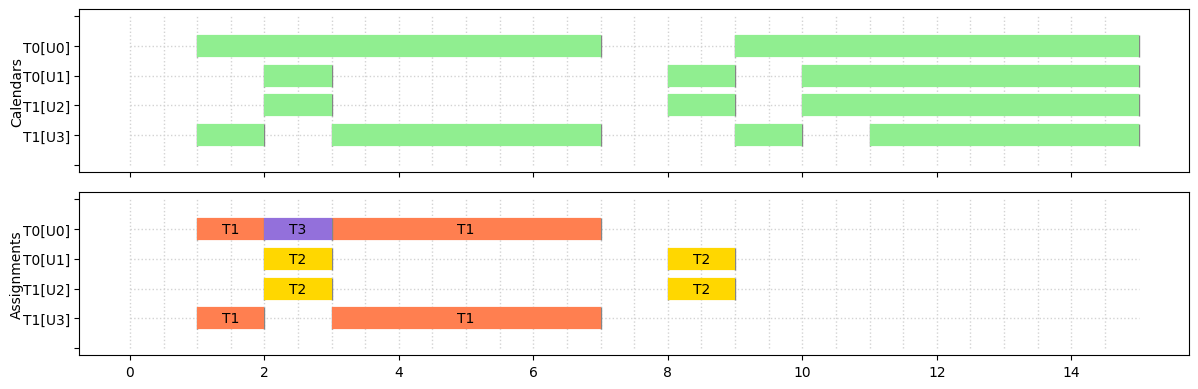

In [ ]:
print("Solving Preemptive (With Delays) | No Migration | Released Resources...")
if sol := mdl.solve(LogVerbosity='Quiet'):
    print(f"\n{'='*75}\n✓ SOLUTION - Makespan: {sol.get_objective_values()[0]}\n{'='*75}")
    print(f"{'Task':<5} {'Start':<5} {'End':<5} {'Mode':<15} {'Segments'}\n{'-'*75}")
    for tid, _, _ in TASKS:
        if t := sol.get_var_solution(T[tid]):
            mode = next((m for m in Task_Modes[tid] 
                        if (ms := sol.get_var_solution(M[(tid, m)])) and ms.is_present()), None)
            mode_str = "{" + ",".join(f"U{r}" for r in mode) + "}" if mode else "—"
            segs = []
            if mode:
                for w in range(len(Work_Windows[(tid, mode)])):
                    if (s := sol.get_var_solution(S[(tid, mode, w)])) and s.is_present() and s.get_size() > 0:
                        segs.append(f"[{s.get_start()}-{s.get_end()})")
            seg_str = ", ".join(segs) if segs else "—"
            
            print(f"T{tid:<4} {t.get_start():<5} {t.get_end():<5} {mode_str:<15} {seg_str}")
    print(f"{'='*75}\n")
    
    # Extract and visualize
    task_assignments = extract_mode_segments(sol, T, M, S, Task_Modes, Work_Windows, TASKS)
    visualize_schedule(sol, RES_MAP, R, TYPES, assignments=task_assignments, origin=0, horizon=12)
else:
    print("No solution found.")

### OptalCP Implementation

In [ ]:
import optalcp as cp

task_modes = build_modes(TASKS, TYPE_MAP)
work_windows = {(tid, m): compute_work_windows(m, RES_MAP) 
                for tid in task_modes for m in task_modes[tid]}

mdl = cp.Model(name="no_migration_delays_released")

# (9a) T_i: master interval
T = {i: mdl.interval_var(name=f"T{i}") for i, _, _ in TASKS}

# (9b) M_{i,m}: mode interval
M = {(i, m): mdl.interval_var(optional=True, name=f"T{i}_M{m}")
     for i in task_modes for m in task_modes[i]}

# (9c) S_{i,m,w}: segment intervals within work windows
S = {(i, m, w): mdl.interval_var(optional=True, start=(ws, we-1), end=(ws+1, we), name=f"T{i}_M{m}_seg{w}")
     for (i, m), windows in work_windows.items() for w, (ws, we) in enumerate(windows)}

# (1) Objective
mdl.minimize(mdl.max([T[i].end() for i in T]))

# (2) Precedences
mdl.add([T[i].end_before_start(T[j]) for i, j in PRECEDENCES])

# (3) Mode selection: alternative
for i, _, _ in TASKS:
    mdl.add(mdl.alternative(T[i], [M[(i, m)] for m in task_modes[i]]))

# (4) Span: mode interval spans its segments
for (i, m), windows in work_windows.items():
    segs = [S[(i, m, w)] for w in range(len(windows))]
    if segs:
        mdl.add(mdl.span(M[(i, m)], segs))

# (5) Work content: if mode selected, segments sum to task size
for i, size, _ in TASKS:
    if size > 0:
        for m in task_modes[i]:
            seg_sum = mdl.sum([S[(i, m, w)].length().guard(0) for w in range(len(work_windows[(i, m)]))])
            mdl.add(mdl.implies(M[(i, m)].presence(), seg_sum == size))

# (7) NoOverlap on segments per resource unit
for r in range(R):
    segs = [S[(i, m, w)] for (i, m, w) in S if r in m]
    if segs:
        mdl.add(mdl.no_overlap(segs))

# Solve
print("Solving No Migration | Delays | Released...")
result = mdl.solve(cp.Parameters(timeLimit=10))

if result.solution:
    sol = result.solution
    print(f"\n{'='*80}\n✓ Makespan: {result.objective_value}\n{'='*80}")
    print(f"{'Task':<6}{'Start':<8}{'End':<8}{'Mode':<18}{'Segments'}")
    print("-" * 80)
    for i, _, _ in TASKS:
        selected = next((m for m in task_modes[i] if sol.is_present(M[(i, m)])), None)
        mode_str = "{" + ",".join(f"U{r}" for r in selected) + "}" if selected else "—"
        segs = []
        if selected:
            for w in range(len(work_windows[(i, selected)])):
                if sol.is_present(S[(i, selected, w)]):
                    segs.append(f"[{sol.get_start(S[(i, selected, w)])}-{sol.get_end(S[(i, selected, w)])})")
        seg_str = ", ".join(segs) if segs else "—"
        print(f"T{i:<5}{sol.get_start(T[i]):<8}{sol.get_end(T[i]):<8}{mode_str:<18}{seg_str}")
else:
    print("No solution found.")

Solving No Migration | Delays | Released...
--------------------------------------------------------------------------------
                         ScheduleOpt OptalCP [Academic]
                           Version 2025.11.1 (Linux)
                CPU: AMD Ryzen 5 5500U with (12 physical cores)
--------------------------------------------------------------------------------
Input parse time: 00:00
Parameters:
   TimeLimit = 10 seconds
Input: no_migration_delays_released
   0 integer variables, 44 interval variables, 37 constraints, 26.9kB
   00:00 Presolving..
Presolved:
   0 integer variables, 38 interval variables, 30 constraints, 25.7kB
   00:00 Starting the search using 12 workers (physical cores count).
--------------------------------------------------------------------------------
   00:00 Lower bound 2 Worker 0
   00:00 Lower bound 3 Worker 0
   00:00 Lower bound 5 Worker 0
   00:00 Lower bound 8 Worker 0
   00:00 Lower bound 9 Worker 0
   00:00 Solution 14 Worker 0: LNS
   0

## Improvement Ideas

Model 4 & 6: Segment Count Explosion

Bounded segment variables: Instead of creating a segment for every window, create a fixed maximum number of "execution chunks" per task/mode and constrain them to fit within windows:

S_{i,m,1}, S_{i,m,2}, ..., S_{i,m,K}  (K = max reasonable preemptions)

Lazy window generation - Only create segment variables for windows that could plausibly be used (based on task duration, release dates, deadlines). Pre-filter during preprocessing.

Model 1 & 5: Symmetry Breaking

If resource units within a type have identical calendars, add symmetry-breaking:
presenceOf(O_{i,r_1}) ≥ presenceOf(O_{i,r_2})  for r_1 < r_2 with same calendar

// When q_{i,k} > 1, break symmetry among selected units
forall(i in N, k in K_i) {
  forall(r1, r2 in U_k : r1 < r2) {
    presenceOf(O_{i,r1}) >= presenceOf(O_{i,r2});
  }
}